## Prediction Models
Predict the instrument based on the input csv files from build dataset.
Uses various sklearn classification models and plots error%

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics

### Load the Datasets
Load the data from the created csv files.

In [4]:
df_train = pd.read_csv('./Extracted CSVs/train.csv')
df_valid = pd.read_csv('./Extracted CSVs/valid.csv')
df_test = pd.read_csv('./Extracted CSVs/test.csv')

### Prepare the Datasets
Balances the data so that both classes have equal entries, to help balance the classification of our implementations.

Seperates the target and data of the classes.

In [5]:
def equalize_data(class1, class2):
    class1_copy = class1
    class2_copy = class2  
   
    if (class1_copy['y_harmonic'].count() < class2_copy['y_harmonic'].count()):
        while (class1_copy['y_harmonic'].count()<class2_copy['y_harmonic'].count()): 
            temp = [class1_copy, class1]
            class1_copy = pd.concat(temp)
        class1_copy = class1_copy[:class2_copy['y_harmonic'].count()]
    else:
        while (class2_copy['y_harmonic'].count()<class1_copy['y_harmonic'].count()):
            temp = [class2_copy, class2]
            class2_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    return (pd.concat([class1_copy, class2_copy]))

def count_errors(predictions):
    count = 0;
    for pred in predictions:
        if (pred[0] != pred[1]):
            count += 1
    return count;

# balance the datasets
input_df_train = equalize_data(df_train[df_train['target'] == 0], df_train[df_train['target'] == 1])
input_df_valid = equalize_data(df_valid[df_valid['target'] == 0], df_valid[df_valid['target'] == 1])
input_df_test = equalize_data(df_test[df_test['target'] == 0], df_test[df_test['target'] == 1])

# randomize datasets
input_df_train = input_df_train.sample(frac=1).reset_index(drop=True)
input_df_valid = input_df_valid.sample(frac=1).reset_index(drop=True)
input_df_test = input_df_test.sample(frac=1).reset_index(drop=True)

# Separate the target and the columns
y_train = input_df_train['target']
x_train = input_df_train.drop(labels=['target'], axis=1)
#Remove the string column
x_train = x_train.drop(x_train.columns[0], axis=1)

# Separate the target and the columns
y_valid = input_df_valid['target']
x_valid = input_df_valid.drop(labels=['target'], axis=1)
#Remove the string column
x_valid = x_valid.drop(x_valid.columns[0], axis=1)

# Separate the target and the columns
y_test = input_df_test['target']
x_test = input_df_test.drop(labels=['target'], axis=1)
#Remove the string column
x_test = x_test.drop(x_test.columns[0], axis=1)

data_length_train = len(x_train)
data_length_valid = len(x_valid)
data_length_test = len(x_test)

### Binary Decision Tree
The first algorithm we used was a Binary Decision Tree. The tree was created and fit to the data using a Sci-kit learn decision tree. Sci-kit learn uses an optimised version of the Classification and Regression Trees (CART) algorithm to construct its decision trees. The CART algorithm “constructs binary trees using the feature and threshold that yield the largest information gain at each node.”

Reference: https://scikit-learn.org/stable/modules/tree.html

In [6]:
def simple_decision_tree(max_depth):
    # hyperparameters
    # max_depth of 4 seems to work well for training with validation set

    # create a scikit-learn tree based on validation set
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf = clf.fit(x_valid, y_valid)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_valid = np.vstack((y_valid, clf.predict(x_valid).tolist())).T

    num_errors_test = count_errors(predictions_test)
    num_errors_valid = count_errors(predictions_valid)

    # calculating valid and test error to two decimal places
    error_percent_valid = round(num_errors_valid / data_length_valid * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Decision Tree: Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', error_percent_valid)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_valid)
    print('Test set error percentage: ', error_percent_test)


Validation set error percentage:  0.0
Test set error percentage:  1.31


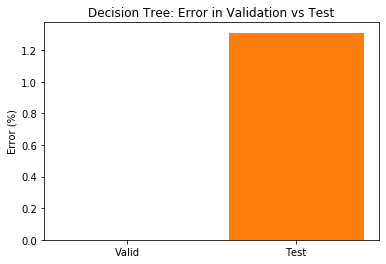

In [19]:
# fit a tree to our data and plot error
simple_decision_tree(4)

### Random Forest
The forest was created and fit to the data using a Sci-kit learn random forest. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

Reference: https://scikit-learn.org/stable/modules/ensemble.html#forest

In [20]:
# random forest implementation
def random_forest(max_depth):
    # hyperparameters
    # max_depth of 4 or 5 seems to work well for training with validation set

    # create a scikit-learn random forest based on validation set
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=100, max_features="sqrt", min_samples_split=2)
    clf = clf.fit(x_valid, y_valid)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_valid = np.vstack((y_valid, clf.predict(x_valid).tolist())).T

    num_errors_test = count_errors(predictions_test)
    num_errors_valid = count_errors(predictions_valid)

    # calculating valid and test error to two decimal places
    error_percent_valid = round(num_errors_valid / data_length_valid * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Random Forest: Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', error_percent_valid)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_valid)
    print('Test set error percentage: ', error_percent_test)

Validation set error percentage:  0.0
Test set error percentage:  0.33


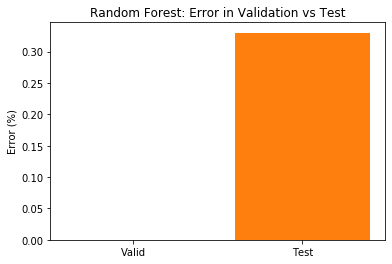

In [21]:
# fit a tree to our data and plot error
random_forest(5)

### AdaBoost
The second algorithm used was AdaBoost which was implemented with Sci-kit learn. Sci-kit learn allows you to define a base estimator which defaults to a DecisionTreeClassifier with a max depth of 1. An estimator is a simple model that can give a classification. Sci-kit learn implements the AdaBoost algorithm to apply heavier weights to specific training estimators with the goal of correcting wrong predictions.

Takes max number of estimators to use, it then uses the train and validation sets to tune the hypeparameters and pick the best outcome. 

Reference: https://scikit-learn.org/stable/modules/ensemble.html#adaboost  

In [22]:
def ada_boost(max_estimators):
    train_results = []
    valid_results = []
    #Tune the hyperparameter estimators
    for estimators in range(1,  max_estimators):
        classifier = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1),
            n_estimators=estimators
        )
        classifier.fit(x_train, y_train)
        predictions_train = classifier.predict(x_train)
        results_train = confusion_matrix(y_train, predictions_train)
        num_errors_train = results_train[0][1] + results_train[1][0]
        train_results.append(num_errors_train)
        predictions_valid = classifier.predict(x_valid)
        results_valid = confusion_matrix(y_valid, predictions_valid)
        num_errors_valid = results_valid[0][1] + results_valid[1][0]
        valid_results.append(num_errors_valid)
        
    estimator_indices = np.arange(1,max_estimators)
    plt.figure(0)
    plt.plot(estimator_indices, train_results, color='r' , label='Train Error')
    plt.plot(estimator_indices, valid_results, color='b' , label='Valid Error')
    plt.legend()
    plt.show()
    
    #Combine the error for each set
    error_results = np.arange(1,max_estimators)
    for i in range(0, len(train_results)):
        error_results[i] = train_results[i] + valid_results[i]
    print(error_results)
    
    best_estimator = np.argmin(error_results) + 1
    print('The Best Estimator found is: ', best_estimator)
    
    classifier = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1),
            n_estimators=best_estimator
    )
    classifier.fit(x_train, y_train)
    
    predictions_train = classifier.predict(x_train)
    results_train = confusion_matrix(y_train, predictions_train)
    num_errors_train = results_train[0][1] + results_train[1][0]
    
    predictions_valid = classifier.predict(x_valid)
    results_valid = confusion_matrix(y_valid, predictions_valid)
    num_errors_valid = results_valid[0][1] + results_valid[1][0]
    
    predictions_test = classifier.predict(x_test)
    results_test = confusion_matrix(y_test, predictions_test)
    num_errors_test = results_test[0][1] + results_test[1][0]
    

    error_percent_train = round(num_errors_train / data_length_train * 100, 2);
    error_percent_valid = round(num_errors_valid / data_length_valid * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Train Set Error', 'Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Train, Validation and Test")
    plt.ylabel("Error (%)")
    plt.bar('Train', error_percent_train)
    plt.bar('Validation', error_percent_valid)
    plt.bar('Test', error_percent_test)

    print('Train set error percentage: ', error_percent_train)
    print('Validation set error percentage: ', error_percent_valid)
    print('Test set error percentage: ', error_percent_test)

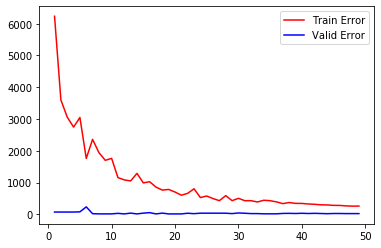

[6304 3668 3130 2814 3123 1991 2376 1952 1710 1772 1183 1093 1085 1298
 1024 1075  866  797  792  711  611  691  821  560  608  527  462  620
  449  543  460  448  408  455  441  404  361  398  367  372  348  343
  321  312  304  302  284  277  279]
The Best Estimator found is:  48
Train set error percentage:  0.66
Validation set error percentage:  1.29
Test set error percentage:  1.31


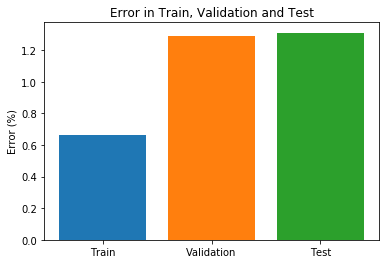

In [26]:
ada_boost(50)

In [27]:
def KNN(k):
    KNN_Classifier = KNeighborsClassifier(n_neighbors = k)
    KNN_Classifier.fit(x_train, y_train)
    
    predictions_train = np.vstack((y_train, KNN_Classifier.predict(x_train).tolist())).T
    length_predictions_train = len(predictions_train)
    num_errors_train = count_errors(predictions_train)
    train_error = round(num_errors_train / length_predictions_train * 100, 2);
    
    predictions_valid = np.vstack((y_valid, KNN_Classifier.predict(x_valid).tolist())).T
    length_predictions_valid = len(predictions_valid)
    num_errors_valid = count_errors(predictions_valid)
    valid_error = round(num_errors_valid / length_predictions_valid * 100, 2);
    
    predictions_test = np.vstack((y_test, KNN_Classifier.predict(x_test).tolist())).T
    length_predictions_test = len(predictions_test)
    num_errors_test = count_errors(predictions_test)
    test_error = round(num_errors_test / length_predictions_test * 100, 2);
    
    errorLabels = ('Train Set Error', 'Valid Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Train vs Valid vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Train', train_error)
    plt.bar('Valid', valid_error)
    plt.bar('Test', test_error)

    print('Train set error percentage: ', train_error)
    print('Valid set error percentage: ', valid_error)
    print('Test set error percentage: ', test_error)
    

Train set error percentage:  5.52
Valid set error percentage:  5.41
Test set error percentage:  5.56


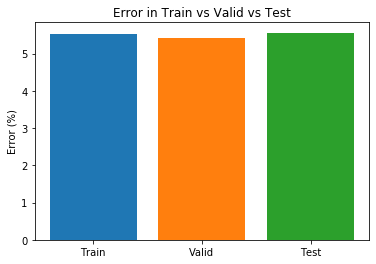

In [28]:
KNN(27)

# Support Vector Machines
Our final prediction model - Support Vector Machines, implemented with Scikit-Learn. This Support Vector Machine (SVM) uses the rbf kernel, with a gamma of 0.00001 and c of 100. This configuration was chosen after testing 25 combonations of gamma and c, following logarithmic increments of each. The SVM is very sensitive to the gamma parameter. A smaller gamma than used would fail to capture the shape, being too constrictive. In SVMs, smaller values of c lead to simpler decision functions. Larger values are more complex. We found 100 did not sacrifice accuracy for efficiency.

In [7]:
def runSVM(k, c, g):   
    x_train_svm=x_train
    x_test_svm = x_test
    x_valid_svm = x_valid

    x_train_svm = x_train_svm.to_numpy()
    x_test_svm = x_test_svm.to_numpy()
    x_valid_svm= x_valid_svm.to_numpy()

    y_train_svm = y_train
    y_train_svm = y_train_svm.values
    
    clf = svm.SVC(kernel=k, C=c, gamma=g)
    clf.fit(x_train, y_train)

    prediction_train = clf.predict(x_train)
    error_train = 100 - 100*metrics.accuracy_score(y_train, prediction_train)
    
    prediction_valid = clf.predict(x_valid)
    error_valid = 100 - 100*metrics.accuracy_score(y_valid, prediction_valid)
    
    prediction_test = clf.predict(x_test)
    error_test = 100 - 100*metrics.accuracy_score(y_test, prediction_test)

    print("Train set error percentage: ", error_train)
    print("Validation set error percentage: ", error_valid)
    print("Test set error percentage: ", error_test)
    
    errorLabels = ('Train Set Error', 'Validation Set Error', 'Test Set Error')
    plt.figure(0)   
    plt.title("Error in Train, Validation and Test")
    plt.ylabel("Error (%)")
    plt.bar('Train', error_train)
    plt.bar('Validation', error_valid)
    plt.bar('Test', error_test)
    plt.ylim([0, 100])
    plt.show()


Train set error percentage:  0.07220216606498298
Validation set error percentage:  0.12285012285012442
Test set error percentage:  0.1633986928104605


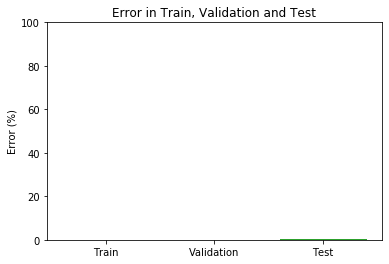

In [10]:
runSVM('rbf', 100, 0.00001)